In [1]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_3_normalised_jit as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 900]


times = np.linspace(20, 97, 78)

df = pd.read_csv('s11_inference_input_multi_well_t_20.csv', header=None)
org_values = np.transpose(df.to_numpy())


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((78,3))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)

# print(st_dev)

# print(np.mean(org_values, axis=1))
# print(centred_moment_3)



Add noise to the data (using random sampling from normal distribution)

In [3]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 3
noise_value = 1
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
# noise_arr[0] = 1
# noise_arr[1] = 1
# noise_arr[2] = 1
# noise_arr[3] = 1


Set-up pints problem and log likelihoods

In [4]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 2
New dimension: 5


Create uniform log prior

In [5]:

# Define the size of the list
size = 5
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 1
prior_arr_upper[1] = 4000
prior_arr_lower[2] = 0
prior_arr_upper[2] = 100
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_24183/504554958.py:25: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [6]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 10000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.3
1     345     0:01.0
2     630     0:01.7
3     927     0:02.4
20    4866    0:12.2
40    8391    0:21.3
60    11889   0:30.4
80    15405   0:39.5
100   18918   0:48.7
120   22353   0:57.6
140   25905   1:06.8
160   29583   1:16.3
180   33426   1:26.1
200   37209   1:35.8
220   41142   1:46.0
240   44727   1:55.2
260   48546   2:05.1
280   51924   2:13.8
300   55614   2:23.4
320   59133   2:32.6
340   62592   2:41.5
360   66093   2:50.5
380   69471   2:59.2
400   73305   3:09.0
420   76788   3:18.0
440   80613   3:27.9
460   84138   3:37.0
480   87726   3:46.3
500   91263   3:55.4
520   94839   4:04.6
540   98211   4:13.3
560   101730   4:22.4
580   105459   4:31.9
600   109014   4:41.1
620   112815   4:50.9
640   116649   5:00.6
660   120165   5:09.7
680   123804   5:19.0
700   127365   5:28.3
720   130740   5:37.0
740   134430   5:46.6
760   137940   5:55.6
780  

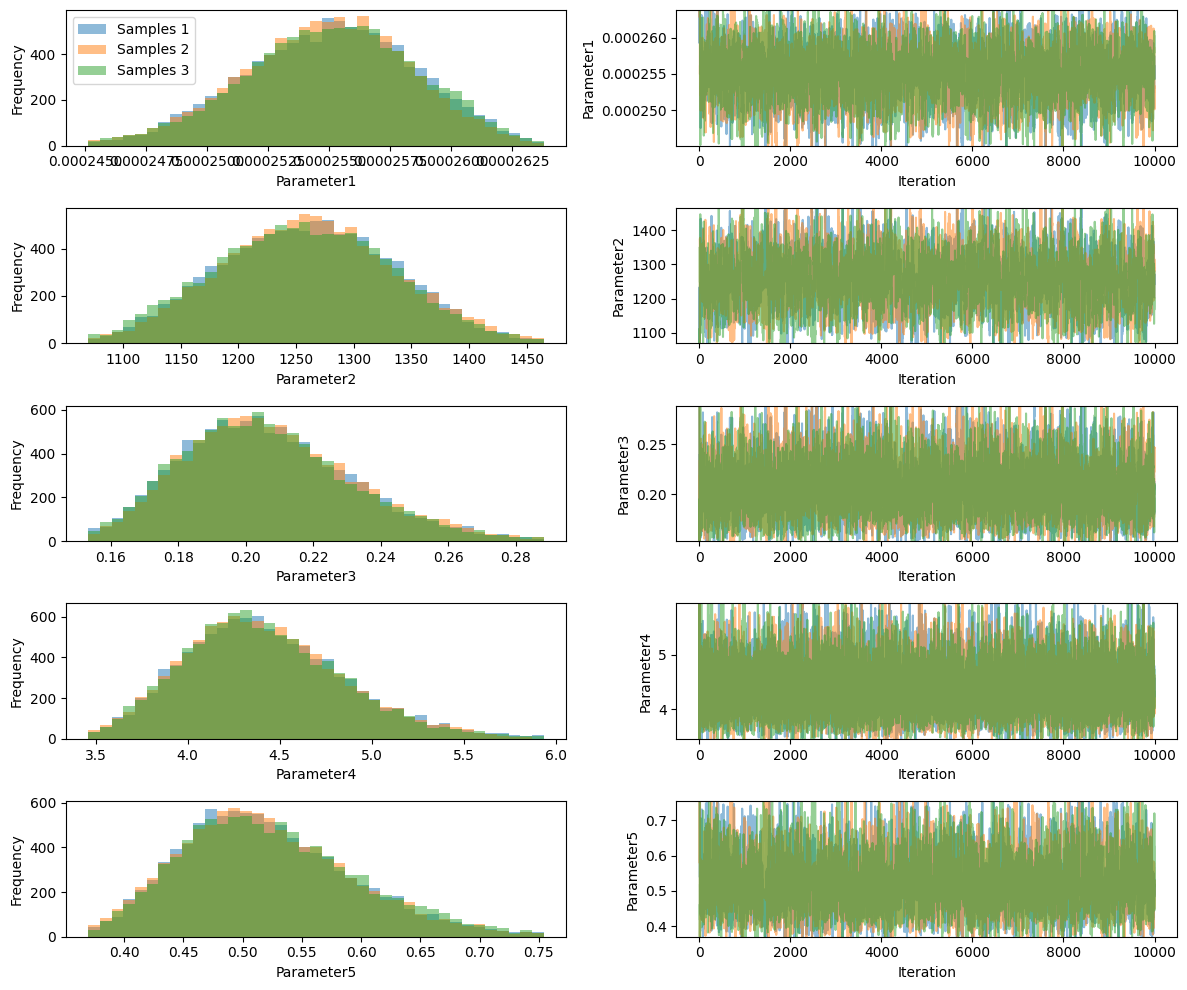

In [7]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [8]:

# ITERS = 100
AllChains = chains[0,100:1000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(900, 5)
[2.50446369e-04 1.33585370e+03 2.14169782e-01 4.64723461e+00
 4.71120298e-01]
[[2.50446369e-04 1.33585370e+03 2.14169782e-01 4.64723461e+00
  4.71120298e-01]
 [2.55194990e-04 1.27851804e+03 1.93929118e-01 4.47677600e+00
  5.44970421e-01]
 [2.54126002e-04 1.23433750e+03 2.02055029e-01 4.50168287e+00
  5.47863228e-01]
 ...
 [2.60458199e-04 1.13270054e+03 1.83143829e-01 3.96142350e+00
  7.11395229e-01]
 [2.60343748e-04 1.11231126e+03 1.83920523e-01 3.77095014e+00
  6.08471264e-01]
 [2.59157041e-04 1.13342064e+03 1.71567601e-01 3.99594343e+00
  5.95226249e-01]]


In [9]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:1000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


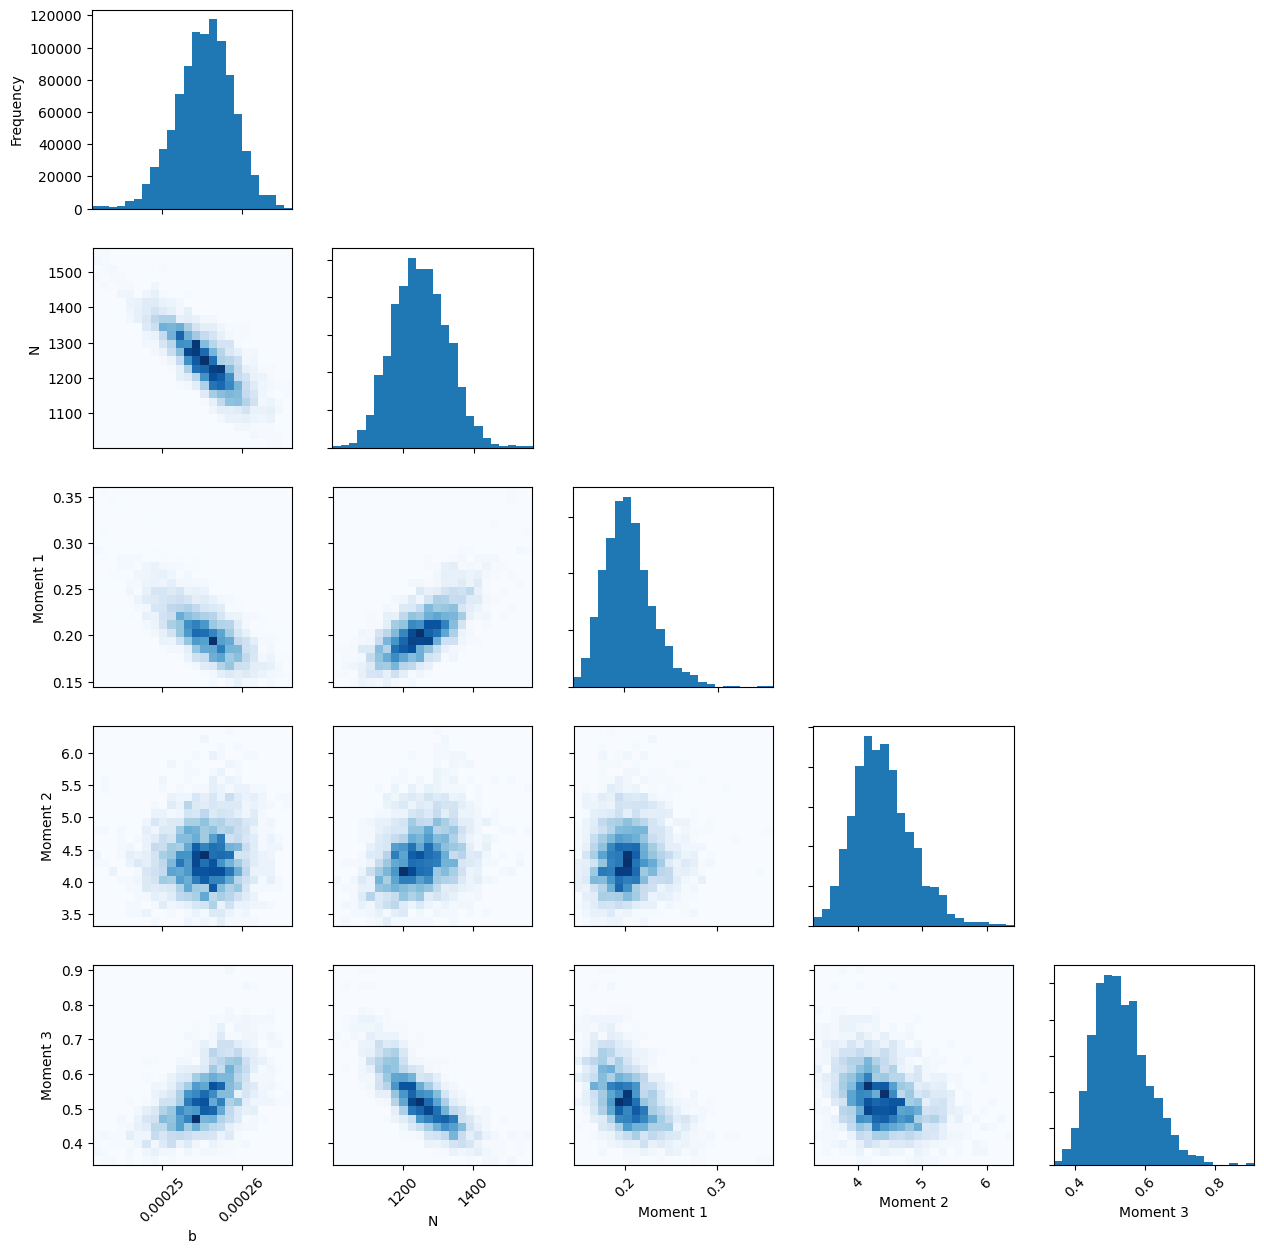

In [11]:


parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3"])
plt.show()

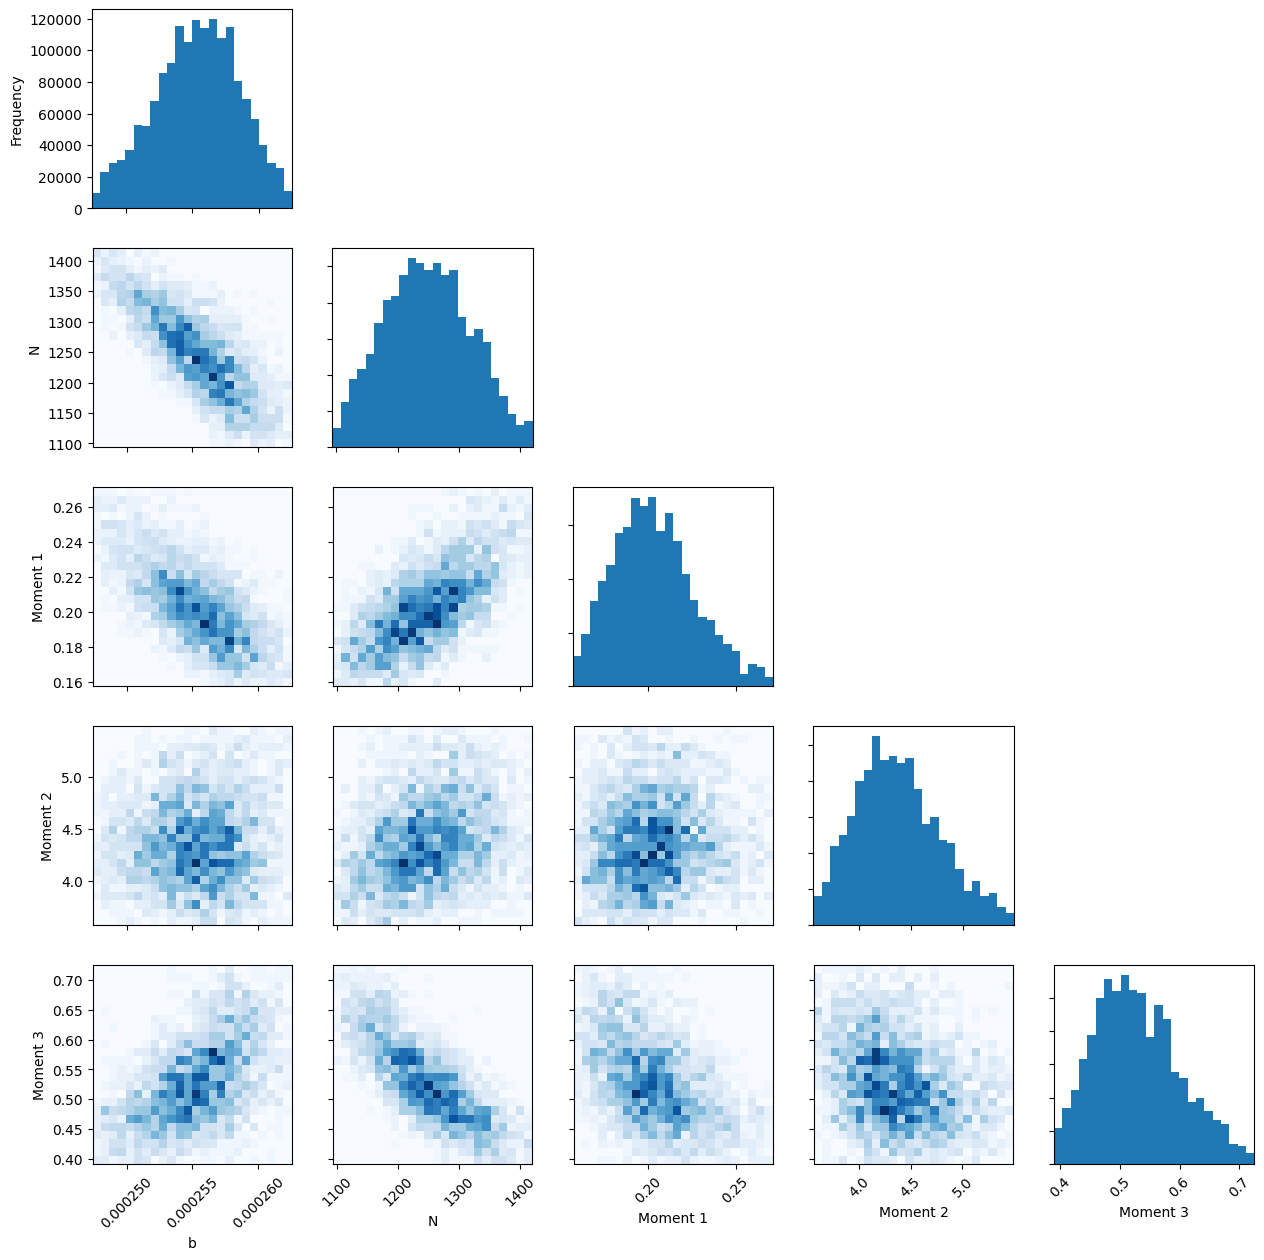

In [12]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3"],
                    n_percentiles=97)
                    
plt.show()

[2.50446369e-04 1.33585370e+03 2.14169782e-01 4.64723461e+00
 4.71120298e-01]


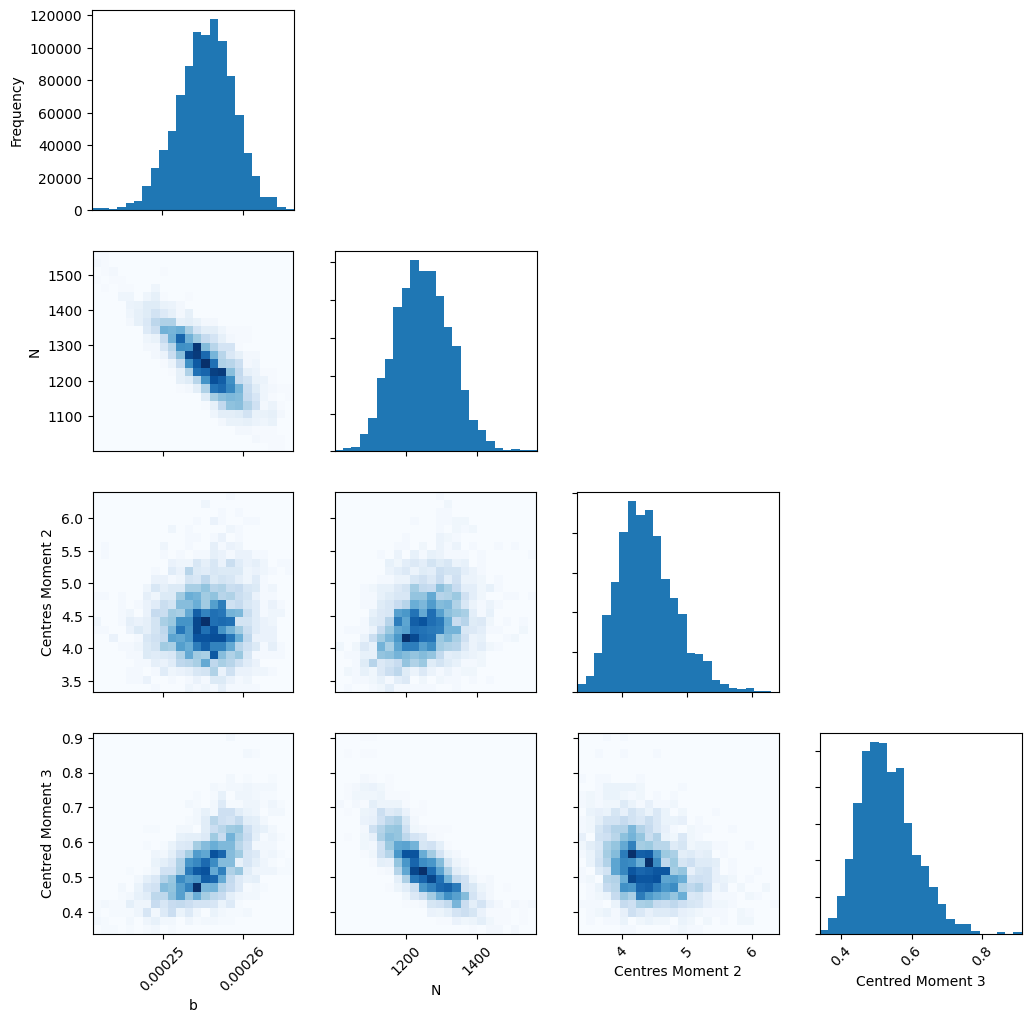

In [14]:
parameter_names = ["b","N", "Moment 2", "Moment 3"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)
print(AllChains[0])
pints.plot.pairwise(AllChains[:,[0,1,3,4]], heatmap=True, 
                    parameter_names=["b","N", "Centres Moment 2", "Centred Moment 3"])
plt.savefig("Pints_pairwise.png", dpi =300)
plt.show()


In [16]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean     std.    2.5%     25%      50%      75%      97.5%    rhat    ess      ess per sec.
--------  -------  ------  -------  -------  -------  -------  -------  ------  -------  --------------
b         0.00     0.00    0.00     0.00     0.00     0.00     0.00     1.00    968.57   0.20
N         1259.11  77.55   1113.87  1203.63  1258.56  1312.38  1412.01  1.00    860.86   0.18
Moment 1  0.21     0.03    0.16     0.19     0.20     0.22     0.26     1.00    1174.21  0.25
Moment 2  4.42     0.45    3.66     4.10     4.38     4.69     5.42     1.00    3116.86  0.66
Moment 3  0.52     0.07    0.40     0.47     0.51     0.57     0.69     1.00    1151.46  0.24


In [17]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [18]:

parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%       97.5%     rhat    ess       ess per sec.
--------  --------  --------  --------  --------  --------  --------  --------  ------  --------  --------------
b         0.000255  3.57e-06  0.000248  0.000253  0.000255  0.000257  0.000262  1       969       0.204
N         1.26e+03  77.6      1.11e+03  1.2e+03   1.26e+03  1.31e+03  1.41e+03  1       861       0.181
Moment 1  0.207     0.026     0.163     0.188     0.204     0.223     0.264     1       1.17e+03  0.247
Moment 2  4.42      0.451     3.66      4.1       4.38      4.69      5.42      1       3.12e+03  0.655
Moment 3  0.522     0.0743    0.398     0.469     0.513     0.568     0.686     1       1.15e+03  0.242


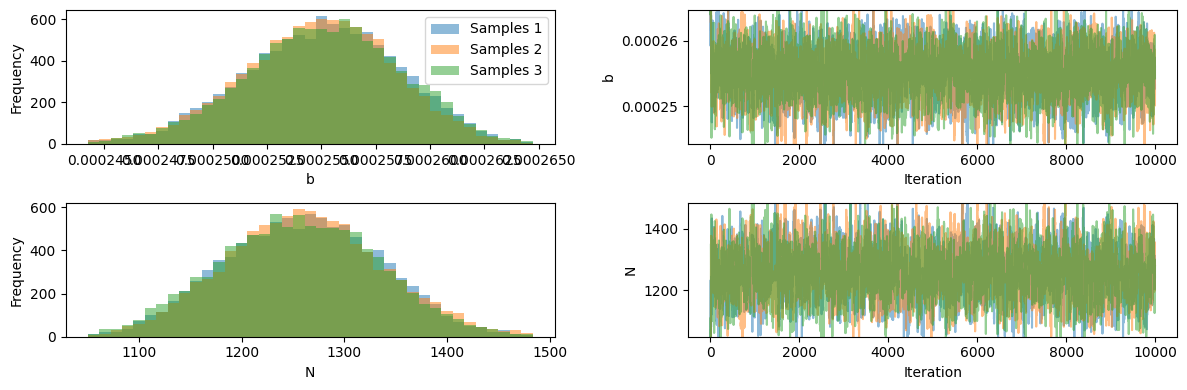

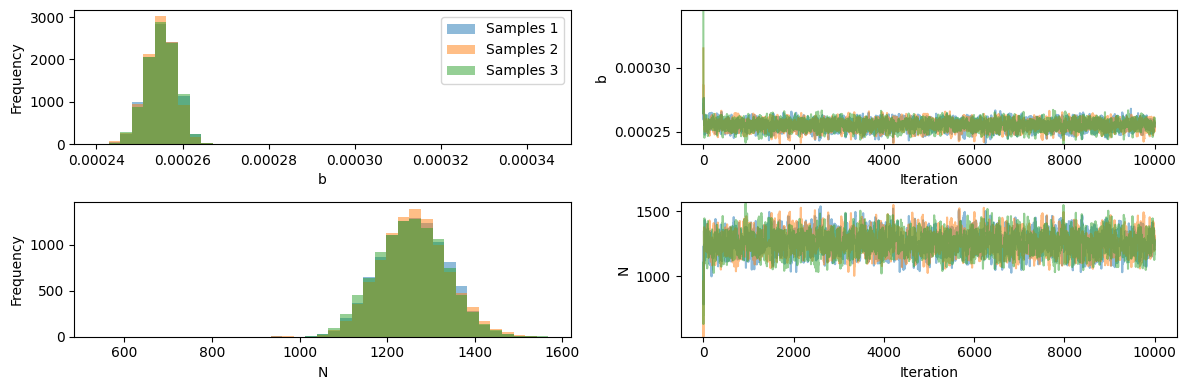

In [19]:
pints.plot.trace(chains[:,:,[0,1]], n_percentiles=99.5, parameter_names=["b","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1]], parameter_names=["b","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()